In [1]:
import time
import numpy as np
import pandas as pd
import math
import tqdm
import tqdm.notebook as tqdm_nb
import tqdm.auto as tqdm_a
from termcolor import colored
from functools import partial
from IPython.display import display

import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (f1_score, precision_score, recall_score,
                             roc_auc_score, roc_curve, auc, precision_recall_curve, confusion_matrix, accuracy_score
                            )
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.impute import SimpleImputer
from sklearn.cluster import SpectralClustering
from sklearn.inspection import permutation_importance

import scipy.stats as sps
from catboost import CatBoostClassifier, CatBoostRegressor

In [2]:
def plot_roc_curve(y, proba, sec_limits=None, label='', color='C0', fig=None, ax=None, return_figure=False):
    fpr, tpr, _ = roc_curve(y, proba)
    area = auc(fpr, tpr)
    
    # fig, ax = check_figax(fig, ax)
    fig.subplots_adjust(hspace=0.1)
    
    ax.plot(fpr, tpr, lw=2, color=color, label=f'{label} auc: {area:.5f}')
    ax.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
    
    if sec_limits is None:
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.0])
    else:
        ax.set_xlim(sec_limits[0])
        ax.set_ylim(sec_limits[1])
        
    ax.set_xlabel('False Positive Rate', fontsize=14)
    ax.set_ylabel('True Positive Rate', fontsize=14)
    ax.set_title('ROC curve', fontsize=15)
    ax.legend(loc='center right', fontsize=12)
    ax.grid()
    
    if return_figure: return fig


def plot_pr_curve(y, proba, sec_limits=None, label='', color='C0', fig=None, ax=None, return_figure=False):
    prec, rec, thres = precision_recall_curve(y, proba)
    area = auc(rec, prec)
    
    # fig, ax = check_figax(fig, ax)
    
    ax.plot(rec, prec, lw=2, color=color, label=f'{label} auc: {area:.5f}')
    
    if sec_limits is None:
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.0])
    else:
        ax.set_xlim(sec_limits[0])
        ax.set_ylim(sec_limits[1])
        
    ax.set_xlabel('Recall', fontsize=14)
    ax.set_ylabel('Precision', fontsize=14)
    ax.set_title('PR curve', fontsize=15)
    ax.legend(loc='center right', fontsize=12)
    ax.grid()
    
    if return_figure: return fig

def plot_confusion(y, pred_label, fig=None, ax=None, return_figure=False, fmt='d'):
    cm = confusion_matrix(y, pred_label)
    
    if ax is None:  # Check if ax is None, and if so, create a new figure and ax.
        fig, ax = plt.subplots(figsize=(8, 8))
        
    ax.set_title('Confusion matrix')
    sns.heatmap(cm, annot=True, cmap='Blues', ax=ax, fmt=fmt)
    
    ax.set_xlabel('\nPredicted values')
    ax.set_ylabel('\nActual values')
    
    if return_figure: return fig

def find_best_threshold(y, proba, method='f1'):
    if method == 'f1':
        prec, rec, thres = precision_recall_curve(y, proba, pos_label=1)
        f1 = 2 * prec * rec / (prec + rec)
        ind = np.nanargmax(f1)
        best_thres = thres[ind]
        
    elif method == 'J':
        fpr, tpr, thres = roc_curve(y, proba, pos_label=1)
        J = tpr - fpr
        ind = np.nanargmax(J)
        best_thres = thres[ind]
        
    return best_thres


def predict_proba_4eval_sets(clf, eval_sets):
    target_proba_sets = list()
    lst_feats = clf.feature_names_
    for i in range(len(eval_sets)):
        X, y = eval_sets[i]
        target_proba_sets.append((y, clf.predict_proba(X[lst_feats])[:, 1]))
        
    return target_proba_sets

def get_metrics_clf(target_proba_sets, eval_names, thres_method='f1'):
    n = len(target_proba_sets)
    metrics_df = list()
    
    for i in range(n):
        y, proba = target_proba_sets[i]
        name = eval_names[i]
        best_thres = find_best_threshold(y, proba, thres_method)
        pred_label = np.where(proba > best_thres, 1, 0)
        
        acc = accuracy_score(y, pred_label)
        f1 = f1_score(y, pred_label)
        prec = precision_score(y, pred_label)
        rec = recall_score(y, pred_label)
        roc_auc = roc_auc_score(y, proba)
        metrics_df.append(pd.DataFrame({'sample': [name],
                                        'roc_auc': [roc_auc],
                                        'Best thres': [best_thres],
                                        'F1': [f1],
                                        'Prec': [prec],
                                        'Rec': [rec]}))
    metrics_df = pd.concat(metrics_df, ignore_index=True)
    
    return metrics_df


def evaluation_clf(target_proba_sets, eval_names, roc_limits=None, pr_limits=None, thres_method='f1'):
    n = len(target_proba_sets)
    colors = [f'C{i}' for i in range(n)]
    
    fig, ax = plt.subplots(ncols=2, figsize=(10,4))
    ax1, ax2 = ax.ravel()
    
    metrics_df = get_metrics_clf(target_proba_sets, eval_names)
    
    for i in range(n):
        y, proba = target_proba_sets[i]
        name = eval_names[i]
        color = colors[i]
        
        best_thres = find_best_threshold(y, proba, thres_method)
        pred_label = np.where(proba > best_thres, 1, 0)
        
        plot_roc_curve(y, proba, label=name, color=color, sec_limits=roc_limits, fig=fig, ax=ax1, return_figure=False)
        fig = plot_pr_curve(y, proba, label=name, color=color, sec_limits=pr_limits, fig=fig, ax=ax2, return_figure=True)
        
    return fig, metrics_df



In [3]:
def build_cb_model(X_train, y_train, X_valid, y_valid, params=None, cat_features=[], 
                   verbose=50, seed=15, n_jobs=-1, fit_kwargs=None, task_type='binary'):
    
    params = {} if params is None else params.copy()
    params['verbose'] = params.get('verbose') or verbose
    params['random_state'] = params.get('random_state') or seed
    params['thread_count'] = params.get('thread_count') or n_jobs
    
    fit_kwargs =  {} if fit_kwargs is None else fit_kwargs.copy()
    
    if task_type == 'binary':
        model = CatBoostClassifier(**params)
        model.fit(
            X_train, y_train,
            eval_set=(X_valid, y_valid),
            cat_features = cat_features,
            **fit_kwargs
        )
        
    elif task_type == 'regression':
        model = CatBoostRegressor(**params)
        model.fit(
            X_train, y_train,
            eval_set=(X_valid, y_valid),
            cat_features = cat_features,
            **fit_kwargs
        )
    else:
        raise ValueError('task should be binary or regression')
        
    return model

def get_feature_importance(model):
    imp = pd.Series(model.feature_importances_,
                   index=model.feature_names_)\
                         .sort_values(ascending=False)\
                         .to_frame()\
                         .reset_index()\
                         .rename(columns={'index': 'feat_name', 0: 'feat_imp'})
    return imp

def plot_feature_importance(model, top_n=None, figsize=None):
    imp = get_feature_importance(model)
    
    fig, ax = plt.subplots(figsize=figsize or (12, 6))
    imp.set_index('feat_name')\
            .sort_values(by='feat_imp')\
            .tail(top_n or len(imp))\
            .plot(kind='barh', color='lightblue', ec='black', ax=ax, width=0.5)
    
    t = f"(Top: {top_n})" if top_n is not None else ""
    ax.set_title("Feature importance " + t)
    ax.grid(False, axis='y')
    
    return fig

def get_permutation_feature_importance(clf, X_test, y_test, scorer, n_repeats=10, seed=15, n_jobs=8, perm_kwargs=None):
    perm_kwargs = {}  if perm_kwargs is None else perm_kwargs.copy()
    perm_kwargs['n_repeats'] = perm_kwargs.get('n_repeats') or n_repeats
    perm_kwargs['random_state'] = perm_kwargs.get('random_state') or seed
    perm_kwargs['n_jobs'] = perm_kwargs.get('n_jobs') or n_jobs
    
    perm_result = permutation_importance(clf, X_test, y_test, scoring=scorer, **perm_kwargs)
    
    perm_imp_df = pd.DataFrame({'feat_name' : clf.feature_names_,
                                'feat_imp' : perm_result['importances_mean'],
                                'feat_imp_std' : perm_result['importances_std']})
    perm_imp_df = perm_imp_df.sort_values(by='feat_imp', ascending=False)\
                                .reset_index(drop=True)
    
    return perm_imp_df


def feat_selection_by_permutation(train_df, test_df, y_train, y_test, lst_feats=None, model_name=None, 
                                 model_params=None, scorer=None, perm_kwargs=None, add_noise_feats=True,
                                 seed=15, n_jobs=-1, fit_kwargs=None):
    model_params = {} if model_params is None else model_params.copy()
    fit_kwargs = {} if fit_kwargs is None else fit_kwargs.copy()
    perm_kwargs = {} if perm_kwargs is None else perm_kwargs.copy()
    
    lst_feats = train_df.columns.to_list() if lst_feats is None else lst_feats.copy()
    lst_cat_feats = [c for c in train_df.select_dtypes(include=['O', 'category']).columns if c in lst_feats]
    
    n_feats = len(lst_feats)
    train_df = train_df.copy()
    tets_df = test_df.copy()
    
    if add_noise_feats:
        train_df['NORMAL'] = sps.norm.rvs(loc=0, scale=1, size=len(train_df), random_state=seed)
        train_df['UNIFORM'] = sps.uniform.rvs(loc=0, scale=1, size=len(train_df), random_state=seed)
        
        test_df['NORMAL'] = sps.norm.rvs(loc=0, scale=1, size=len(test_df), random_state=seed)
        test_df['UNIFORM'] = sps.uniform.rvs(loc=0, scale=1, size=len(test_df), random_state=seed)
        lst_feats += ['NORMAL', 'UNIFORM']
        
    print(f">> Building model: {model_name}")
    start_t = time.time()
    
    if model_name == 'catboost':
        clf = build_cb_model(train_df[lst_feats], y_train, test_df[lst_feats], y_test,
                            cat_features=lst_cat_feats,
                            params=model_params,
                            verbose=0, seed=seed, n_jobs=-1, fit_kwargs=fit_kwargs)
    else:
        raise ValueError('incorrect model name')
        
    end_t = time.time()
    print(f">> Done ({end_t - start_t:.2f}s)")
    
    print(f"Start permutation", "with adding noise feats" if add_noise_feats else "", "...")
    
    perm_imp_df = get_permutation_feature_importance(clf, test_df[lst_feats], y_test, scorer, seed=seed, **perm_kwargs)
    
    if add_noise_feats:
        uniform_perm_value = perm_imp_df[perm_imp_df.feat_name == 'UNIFORM']['feat_imp'].values[0]
        normal_perm_value = perm_imp_df[perm_imp_df.feat_name == 'NORMAL']['feat_imp'].values[0]
        perm_filter = (perm_imp_df.feat_imp <= max(0, normal_perm_value, uniform_perm_value))
        perm_imp_df = perm_imp_df[~perm_filter].reset_index(drop=True)
        train_df.drop(['NORMAL', 'UNIFORM'], axis=1, inplace=True)
        test_df.drop(['NORMAL', 'UNIFORM'], axis=1, inplace=True)
    else:
        perm_filter = (perm_imp_df.feat_imp <= 0)
        perm_imp_df = perm_imp_df[~perm_filter].reset_index(drop=True)
        
    perm_imp_df = perm_imp_df.reset_index(drop=True)
    lst_sel_feats = perm_imp_df['feat_name'].to_list()
    
    end_t = time.time()
    print(f">> Done ({end_t - start_t:.2f}s)")
    print(f"Reduced number of feats: {n_feats} -> {len(lst_sel_feats)}")
    
    return perm_imp_df, lst_sel_feats

def custom_forward_selection(X_train, y_train, X_test, y_test, task_type='binary', eval_sets=None, eval_names=None,
                            lst_feats_for_select=None, cat_features=None, scorer=None, maximize_score=None, maximize_eval_name='Test',
                            metric_thres=1e-5, step=1, method='fast', reorder_init=False, model_name='catboost', model_params=None,
                             seed=15, n_jobs=-1, perm_kwargs=None, fit_kwargs=None):
    
    init_features = X_train.columns.to_list() if lst_feats_for_select is None else lst_feats_for_select
    cat_features = [] if cat_features is None else cat_features
    init_cat_features = [c for c in cat_features if c in set(init_features)]
    
    eval_sets = [(X_train, y_train), (X_test, y_test)] if eval_sets is None else eval_sets
    eval_names = ['Train', 'Test'] if eval_names is None else eval_names
    
    num_fs_steps = len(init_features)
    sign_coef = 1 if maximize_score else -1
    bad_fs_feats = []
    stop_selection_flag = False
    start_i = 0
    sel_features = []
    
    scores = {name : [] for name in eval_names}
    history = dict()
    history['metrics'] = list()
    history['scores'] = list()
    history['num_feats'] = list()
    history['sel_feats'] = list()
    history['iteration'] = list()
    
    progress = tqdm.tqdm(desc='fs_step')
    while not stop_selection_flag:
        excluded_feat = None
        
        n = len(init_features)
        n_iteration = (n + step - 1) // step
        
        for i in range(start_i, n_iteration):
            from_feat_idx = i * step
            to_feat_idx = (i + 1) * step
            feats = init_features[from_feat_idx: to_feat_idx]
            
            sel_features.extend(feats)
            print(sel_features)
            sel_cat_features = [c for c in init_cat_features if c in sel_features]
            
            print(f'--- Iteration: {i}. Number of feats: {to_feat_idx}/{n} ---')
            print(f'>> Building model: {model_name}')
            start_t = time.time()
            
            clf = build_cb_model(X_train[sel_features], y_train, 
                                     X_test[sel_features], y_test,
                                     cat_features=sel_cat_features, params=model_params,
                                     verbose=0, seed=seed, n_jobs=n_jobs, fit_kwargs=None)
            
            target_proba_sets = predict_proba_4eval_sets(clf, eval_sets)
            metrics_df = get_metrics_clf(target_proba_sets, eval_names=eval_names)
            display(metrics_df)
            
            for eval_samp, eval_name in zip(eval_sets, eval_names):
                score = scorer(clf, eval_samp[0][clf.feature_names_], eval_samp[1])
                scores[eval_name].append(score)
                
            end_t = time.time()
            print(f'>> Done ({end_t  - start_t:.2f}s)')
            
            if i > start_i:
                prev_valid = scores[maximize_eval_name][-2]
                curr_valid = scores[maximize_eval_name][-1]
                d_valid = sign_coef * (curr_valid - prev_valid)
                
                if (d_valid <= metric_thres):
                    print('>> Excluded:', feats)
                    print(*[f'>> score increase_{name}: {sign_coef*np.diff(scores[name][-2:])[0]:.3f}' for name in eval_names], sep='\n')
                    
                    new_init_features = [c for c in init_features if c not in set(feats)]
                    new_init_cat_features = [c for c in cat_features if c in set(new_init_features)]
                    
                    if reorder_init:
                        clf = build_cb_model(X_train[new_init_features], y_train,
                                                 X_test[new_init_features], y_test,
                                                 cat_features=new_init_cat_features, params=model_params,
                                                 verbose=0, seed=seed,  n_jobs=n_jobs, fit_kwargs=None)
                        start_t = time.time()
                        print(f'>> Start sorted features after excluding. Method: {method}')
                        if method == 'fast':
                            new_init_sorted_features = get_feature_importance(clf)['feat_name'].to_list()
                        elif method == 'permutation':
                            new_init_sorted_features = get_permutation_feature_importance(clf, X_test[new_init_features],
                                                                                          y_test, scorer)['feat_name'].to_list()
                            
                    init_features = new_init_sorted_features.copy() if reorder_init else new_init_features.copy()
                    init_cat_features = [c for c in cat_features if c in set(init_features)]
                    
                    excluded_feat = feats
                    bad_fs_feats.extend(excluded_feat)
                    
                    end_t = time.time()
                    print(f'>> Done ({end_t - start_t:.2f}s)')
                    break
                    
            history['metrics'].append(metrics_df)
            history['scores'].append(scores)
            history['num_feats'].append(len(sel_features))
            history['sel_feats'].append(sel_features.copy())
            history['iteration'].append(i)
                                        
        if excluded_feat is None:
            stop_selection_flag = True
        else:
            if reorder_init:
                start_i = 0
                sel_features = []
                scores = {name: [] for name in eval_names}
                history = dict()
                history['metrics'] = list()
                history['scores'] = list()
                history['num_feats'] = list()
                history['sel_feats'] = list()
                history['iteration'] = list()                     
            else:
                start_i = from_feat_idx
                sel_features = init_features[:start_i]                       

        progress.update()
        print('*'*50)
    print(f'>> Finish. Number of features in final subset: {len(sel_features)}')

    return(history)

In [4]:
df = pd.read_csv('train_dataset_Самолет.csv')

C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_15644\1363469232.py:1: DtypeWarning: Columns (51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,131,132,133,135,136,139,140,141,142,143,144,145,146,147,148,149,151,152,155,156,157,158,159,160,161,163,164,165,167,168,169,171,172,173,174,175,176,177,178,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,223,224,227,239,240,241,242,243,244,245,246,459,460,461,467,468,469,515,516,523,524,531,532,539,540,547,548,555,556,563,564,565,567,571,572,573,575,579,580,581,582,583,587,588,595,596,603,604,611,612,613,615,795,796,797,799,821,822,825,826,1031,1032,1033,1034,1035,1036,1037,1039,1040,1041,1042,1043,1044,1045,1047,1048,1049,1050,1051,1052,1055,1056,1057,1058,1059,1060,1063,1064,1065,1067,1068,1069,1072,1073,1074,1075,1076,1077,1078,1172,1173,1174,1176,1177,1178,1179,1180,1181,1182,1275,1276,1277,1278,1279,1280,1281,

In [5]:
df.head()

,report_date,client_id,target,col1,col2,col3,col4,col5,col6,col7,...,col2654,col2655,col2656,col2657,col2658,col2659,col2660,col2661,col2662,col2663
0,2022-11-01,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.256261
1,2022-11-01,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7616803.0,7616803.0,7616803.0,NaN,NaN,NaN,7616803.0,7616803.0,7616803.0,0.256261
2,2022-05-01,6,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.256261
3,2022-09-01,7,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.258682
4,2022-08-01,8,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254164


In [6]:
df.shape

(14456, 2666)

In [7]:
df.report_date = pd.to_datetime(df.report_date)

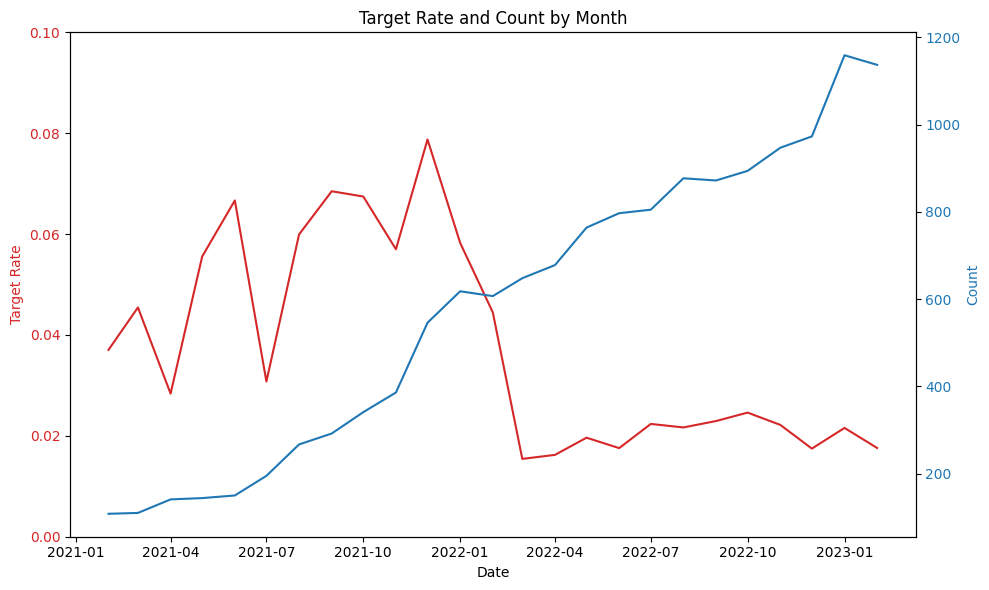

In [8]:
df['year_month'] = df['report_date'].dt.to_period('M')

# Group by month and year
grouped = df.groupby('year_month').agg(
    target_rate=('target', 'mean'),
    count=('target', 'size')
)

grouped.index = grouped.index.astype('datetime64[ns]')
fig, ax1 = plt.subplots(figsize=(10, 6))


# Plot target rate on the left y-axis
color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylim([0, 0.1])
ax1.set_ylabel('Target Rate', color=color)
ax1.plot(grouped.index, grouped['target_rate'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create another y-axis for the count
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Count', color=color)
ax2.plot(grouped.index, grouped['count'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Target Rate and Count by Month')
plt.tight_layout()
plt.show()

In [9]:
ignore_features = ['report_date', 'client_id', 'target', 'year_month']

In [10]:
nan_percentage = df.isna().mean()
cols_to_drop = nan_percentage[nan_percentage > 0.95].index
df_cleaned = df.drop(columns=cols_to_drop)

In [11]:
len(cols_to_drop)

1692

In [12]:
df_cleaned.shape

(14456, 975)

In [13]:
def get_correlated_feats(corr_matrix, feat_stats, greater_is_better=True, corr_threshold=0.9):
    cols = corr_matrix.columns.to_list()
    dropped = {col:0 for col in cols}
    for col in tqdm.tqdm(cols, desc='Get correlated features'):
        if dropped[col] == 0:
            columns_to_check = corr_matrix.index.values[np.abs(corr_matrix[col]) >= corr_threshold]
            if len(columns_to_check) > 1:
                print(f'{col} -> {columns_to_check}')
                if feat_stats is None:
                    bad_cols = columns_to_check[1:]
                else:
                    sel_stats = feat_stats.loc[columns_to_check]
                    if greater_is_better:
                        bad_cond = np.abs(sel_stats) < np.abs(sel_stats).max()
                    else:
                        bad_cond = np.abs(sel_stats) > np.abs(sel_stats).min()
                        
                    bad_cols = sel_stats[bad_cond].index.to_list()
                    norm_cols = sel_stats[~bad_cond].index.to_list()
                    if len(norm_cols) > 1:
                        for norm_col in norm_cols[1:]:
                            dropped[norm_col] += 1
                            
                for bad_col in bad_cols:
                    dropped[bad_col] += 1
                
    high_corr_cols = [c for c in dropped.keys() if dropped[c] > 0]
    return high_corr_cols

In [14]:
corr_mx = df_cleaned.drop(columns=ignore_features).corr()

C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_15644\2432034929.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_mx = df_cleaned.drop(columns=ignore_features).corr()


In [15]:
corr_feats = get_correlated_feats(corr_mx, feat_stats=nan_percentage, greater_is_better=False, corr_threshold=0.9)

Get correlated features:  76%|████████████████████████████████████████▎            | 705/928 [00:00<00:00, 3561.81it/s]

col280 -> ['col280' 'col320']
col284 -> ['col284' 'col324']
col288 -> ['col288' 'col292' 'col328']
col296 -> ['col292' 'col296']
col300 -> ['col300' 'col340']
col304 -> ['col304' 'col344']
col308 -> ['col308' 'col312' 'col348']
col316 -> ['col312' 'col316']
col320 -> ['col280' 'col320']
col324 -> ['col284' 'col324']
col328 -> ['col288' 'col328' 'col332']
col340 -> ['col300' 'col340']
col344 -> ['col304' 'col344']
col348 -> ['col308' 'col348' 'col352']
col388 -> ['col388' 'col392']
col396 -> ['col392' 'col396']
col408 -> ['col408' 'col412']
col420 -> ['col420' 'col428']
col448 -> ['col448' 'col452']
col474 -> ['col474' 'col475' 'col482' 'col483' 'col484' 'col486' 'col490' 'col491']
col476 -> ['col475' 'col476' 'col484']
col478 -> ['col478' 'col482' 'col483' 'col486']
col487 -> ['col475' 'col482' 'col483' 'col484' 'col486' 'col487' 'col488' 'col490'
 'col491']
col492 -> ['col482' 'col483' 'col484' 'col486' 'col488' 'col490' 'col491' 'col492']
col494 -> ['col494' 'col495' 'col496' 'col502

Get correlated features: 100%|█████████████████████████████████████████████████████| 928/928 [00:00<00:00, 3995.56it/s]

col2359 -> ['col2054' 'col2055' 'col2057' 'col2060' 'col2063' 'col2064' 'col2069'
 'col2070' 'col2346' 'col2347' 'col2348' 'col2349' 'col2350' 'col2351'
 'col2353' 'col2354' 'col2355' 'col2356' 'col2357' 'col2358' 'col2359'
 'col2360' 'col2361' 'col2362' 'col2363' 'col2364' 'col2365' 'col2366'
 'col2395' 'col2396' 'col2398' 'col2399' 'col2401' 'col2402' 'col2404'
 'col2405' 'col2407' 'col2408' 'col2413' 'col2414']
col2364 -> ['col2053' 'col2055' 'col2056' 'col2058' 'col2059' 'col2061' 'col2062'
 'col2064' 'col2068' 'col2070' 'col2107' 'col2110' 'col2116' 'col2346'
 'col2347' 'col2348' 'col2349' 'col2350' 'col2351' 'col2352' 'col2353'
 'col2354' 'col2355' 'col2356' 'col2357' 'col2358' 'col2359' 'col2360'
 'col2361' 'col2362' 'col2363' 'col2364' 'col2366' 'col2388' 'col2394'
 'col2396' 'col2397' 'col2399' 'col2400' 'col2402' 'col2403' 'col2405'
 'col2406' 'col2408' 'col2412' 'col2414']
col2377 -> ['col2078' 'col2079' 'col2081' 'col2082' 'col2371' 'col2372' 'col2374'
 'col2375' 'col2377' 

In [16]:
len(corr_feats)

502

In [17]:
df_no_corr = df_cleaned.drop(columns=corr_feats)
df_no_corr.shape

(14456, 473)

In [18]:
df_new = df_no_corr.copy()
df_new['report_date'] = df_new['report_date'].astype('datetime64[ns]')
df_new = df_new.sort_values(by='report_date')

def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union

def compare_columns(df):
    columns = df.columns
    results = pd.DataFrame(index=columns, columns=columns)

    for col1 in tqdm.tqdm(columns):
        for col2 in columns:
            set1 = set(df[col1].dropna().unique())
            set2 = set(df[col2].dropna().unique())
            results.loc[col1, col2] = jaccard_similarity(set1, set2)

    return results

cat_columns = df_new.select_dtypes('object')
compare_df = compare_columns(cat_columns)

def get_unique_columns(similarity_matrix, threshold=0.26):

    columns_to_remove = set()
    for i in range(similarity_matrix.shape[0]):
        for j in range(i+1, similarity_matrix.shape[1]):
            if isinstance(similarity_matrix, np.ndarray):
                value = similarity_matrix[i, j]
            else:  # Если это DataFrame
                value = similarity_matrix.iloc[i, j]
            if value >= threshold:
                columns_to_remove.add(j)

    # Получить названия удаленных колонок (если это DataFrame)
    if isinstance(similarity_matrix, pd.DataFrame):
        removed_column_names = [similarity_matrix.columns[i] for i in columns_to_remove]

    # Удалить дублирующиеся колонки из матрицы
    if isinstance(similarity_matrix, np.ndarray):
        updated_matrix = np.delete(similarity_matrix, list(columns_to_remove), axis=1)
        updated_matrix = np.delete(updated_matrix, list(columns_to_remove), axis=0)
    else:  # Если это DataFrame
        updated_matrix = similarity_matrix.drop(similarity_matrix.columns[list(columns_to_remove)], axis=1)
        updated_matrix = updated_matrix.drop(similarity_matrix.index[list(columns_to_remove)], axis=0)

    return updated_matrix

mat = get_unique_columns(compare_df)

100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:02<00:00, 19.07it/s]


In [19]:
len(mat.columns.values)

18

In [22]:
model_df = df_new.copy()

In [24]:
train_mask = (model_df.report_date <= '2022-09-01')
valid_mask = (model_df.report_date > '2022-09-01') & (model_df.report_date <= '2023-01-01')
oot_mask = model_df.report_date > '2023-01-01'

model_df.loc[train_mask, 'sample'] = 'Train'
model_df.loc[valid_mask, 'sample'] = 'Valid(OOT)'
model_df.loc[oot_mask, 'sample'] = 'Test(OOT)'

In [25]:
def get_samp_descr_for_binary_task(df, sample_col, date_col, target_col, feature_cols):
    sample_names = df[sample_col].unique()
    for name in sample_names:
        samp = df[df[sample_col] == name]
        print(colored(f'{name:}', None, attrs=['bold']))
        print('Period from:', samp[date_col].dt.date.min(), 'to', samp[date_col].dt.date.max())
        print('Target rate:', round(samp[target_col].mean(), 6))
        print('Count of target 1:', samp[target_col].sum())
        print('Shape of sample:', samp[feature_cols].shape)
        print('--------------------------------------------------------------------')

In [26]:
sample = 'sample'
target = 'target'
report_date = 'report_date'

In [27]:
nums = df_new.select_dtypes(include=['int64', 'float64']).columns.tolist()
cats = list(set(mat.columns.to_list() + df_new.select_dtypes(include=['O']).columns.tolist()))

ignore_features = ['report_date', 'client_id', 'target', 'year_month', 'sample', 'col1454']
cat_features = [c for c in cats if c not in ignore_features]
cols = [c for c in nums if c not in ignore_features] + cat_features

In [28]:
get_samp_descr_for_binary_task(model_df, sample_col=sample, date_col=report_date, target_col=target, feature_cols=cols)

Train
Period from: 2021-02-01 to 2022-09-01
Target rate: 0.035416
Count of target 1: 331
Shape of sample: (9346, 468)
--------------------------------------------------------------------
Valid(OOT)
Period from: 2022-10-01 to 2023-01-01
Target rate: 0.021394
Count of target 1: 85
Shape of sample: (3973, 468)
--------------------------------------------------------------------
Test(OOT)
Period from: 2023-02-01 to 2023-02-01
Target rate: 0.01759
Count of target 1: 20
Shape of sample: (1137, 468)
--------------------------------------------------------------------


In [29]:
model_df[cat_features] = model_df[cat_features].fillna('unknown')

In [30]:
for col in cat_features:
    model_df[col] = model_df[col].astype(str)

In [31]:
catboost_params = {
    'iterations': 200,
    'learning_rate': 0.01,
    'depth': 6,
    'eval_metric': 'AUC',
    # 'class_weights': [1, (2296 / 45)]
}

In [32]:
clf = build_cb_model(model_df[train_mask][cols], model_df[train_mask].target,
                     model_df[valid_mask][cols], model_df[valid_mask].target, 
                     cat_features=cat_features, params=catboost_params)

0:	test: 0.5985158	best: 0.5985158 (0)	total: 206ms	remaining: 40.9s
50:	test: 0.7281575	best: 0.7334408 (40)	total: 3.8s	remaining: 11.1s
100:	test: 0.7704475	best: 0.7707985 (94)	total: 7.26s	remaining: 7.12s
150:	test: 0.7844060	best: 0.7844060 (148)	total: 10.9s	remaining: 3.54s
199:	test: 0.8018322	best: 0.8019593 (198)	total: 14.6s	remaining: 0us

bestTest = 0.8019592714
bestIteration = 198

Shrink model to first 199 iterations.


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.863214,0.118463,0.350626,0.429825,0.296073
1,Valid(OOT),0.801959,0.087741,0.193548,0.214286,0.176471


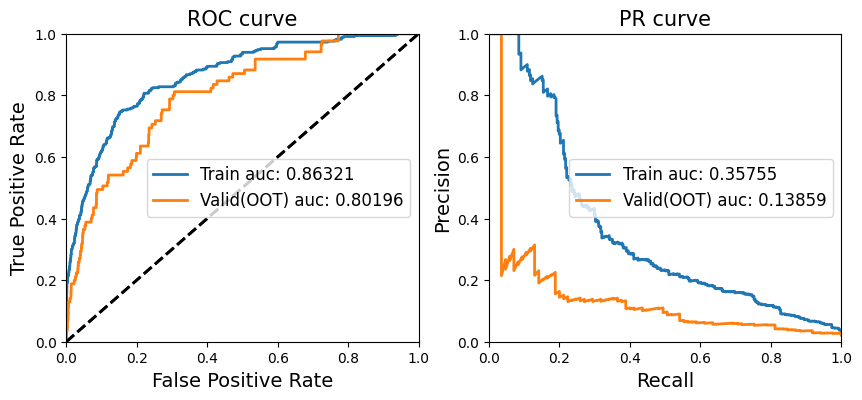

In [33]:
target_proba_sets = predict_proba_4eval_sets(clf, [(model_df[train_mask][cols], model_df[train_mask].target),
                     (model_df[valid_mask][cols], model_df[valid_mask].target)])

fig, metrics_df = evaluation_clf(target_proba_sets, ['Train', 'Valid(OOT)'], thres_method='J')

display(metrics_df)

In [34]:
imp = get_feature_importance(clf)

In [35]:
zero_imp = imp[imp.feat_imp == 0.0].feat_name.values

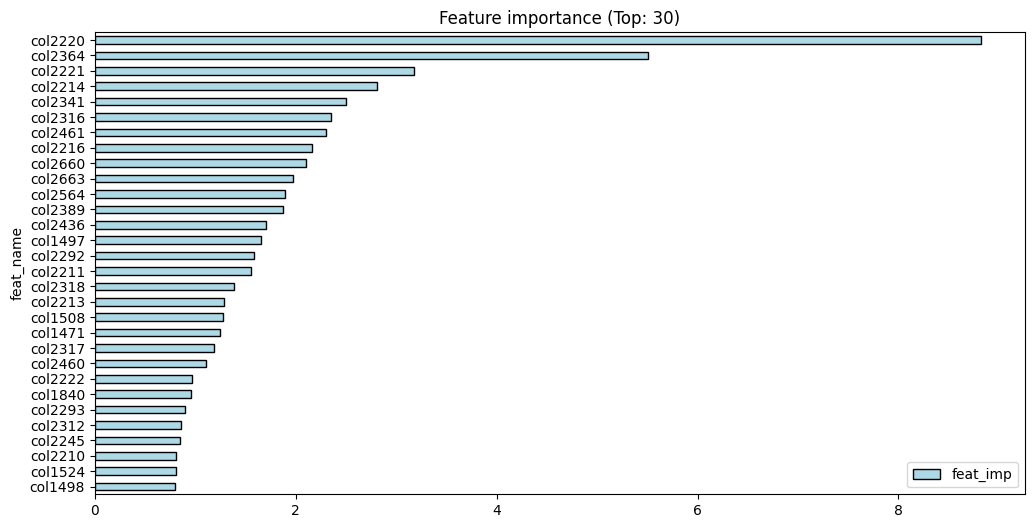

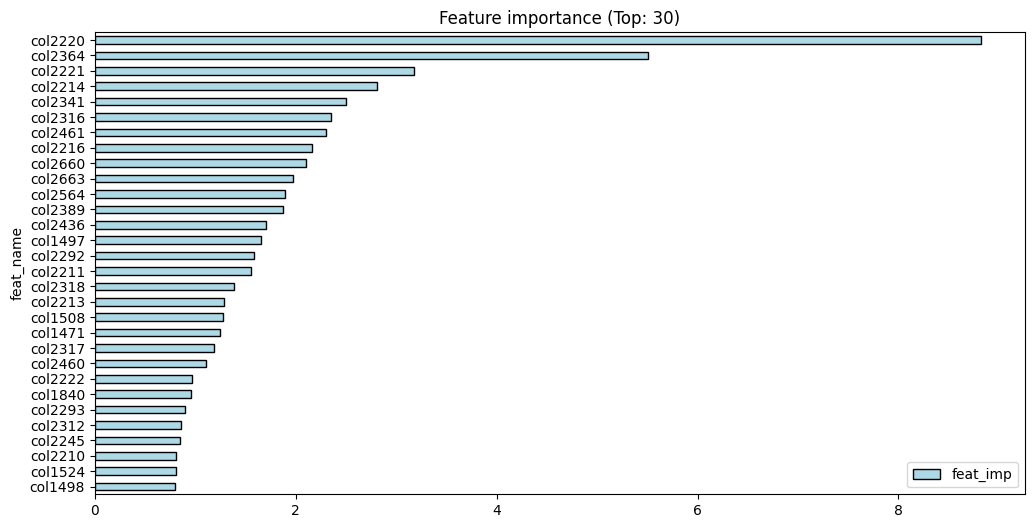

In [36]:
plot_feature_importance(clf, top_n=30)

In [37]:
model_df = model_df.drop(columns=zero_imp)

In [38]:
cols = model_df.drop(columns=ignore_features).columns.to_list()
cat_features = model_df[cols].select_dtypes(include=['object']).columns.tolist()

In [39]:
clf = build_cb_model(model_df[train_mask][cols], model_df[train_mask].target,
                     model_df[valid_mask][cols], model_df[valid_mask].target, 
                     cat_features=cat_features, params=catboost_params)

0:	test: 0.6338644	best: 0.6338644 (0)	total: 52.4ms	remaining: 10.4s
50:	test: 0.7405925	best: 0.7405925 (50)	total: 3.05s	remaining: 8.91s
100:	test: 0.7772074	best: 0.7772074 (100)	total: 6.11s	remaining: 5.99s
150:	test: 0.7966579	best: 0.7966579 (150)	total: 9.11s	remaining: 2.96s
199:	test: 0.8070095	best: 0.8073454 (193)	total: 12.1s	remaining: 0us

bestTest = 0.8073453764
bestIteration = 193

Shrink model to first 194 iterations.


last_num_feats = len(model_df[cols])  # starting with all features
convergence = False

while not convergence:
    perm_imp_df, lst_sel_feats = feat_selection_by_permutation(
        model_df[cols][train_mask], model_df[cols][valid_mask], 
        model_df[train_mask].target, model_df[valid_mask].target, lst_feats=cols, 
        model_name='catboost', model_params=catboost_params, scorer='roc_auc')
    
    if len(lst_sel_feats) == last_num_feats:
    # if len(lst_sel_feats) < 30:
        convergence = True
    else:
        last_num_feats = len(lst_sel_feats)
        cols = lst_sel_feats 


In [40]:
perm_imp_df, lst_sel_feats = feat_selection_by_permutation(
    model_df[cols][train_mask], model_df[cols][valid_mask], 
    model_df[train_mask].target, model_df[valid_mask].target, lst_feats=cols, 
    model_name='catboost', model_params=catboost_params, scorer='roc_auc')

>> Building model: catboost
>> Done (12.69s)
Start permutation with adding noise feats ...
>> Done (34.57s)
Reduced number of feats: 302 -> 43


In [41]:
cols = lst_sel_feats.copy()
cat_features = model_df[cols].select_dtypes(include=['object']).columns.tolist()

In [42]:
clf = build_cb_model(model_df[train_mask][cols], model_df[train_mask].target,
                     model_df[valid_mask][cols], model_df[valid_mask].target, 
                     cat_features=cat_features, params=catboost_params)

0:	test: 0.6496233	best: 0.6496233 (0)	total: 5.08ms	remaining: 1.01s
50:	test: 0.8150372	best: 0.8158693 (48)	total: 245ms	remaining: 716ms
100:	test: 0.8221133	best: 0.8246974 (76)	total: 466ms	remaining: 457ms
150:	test: 0.8340353	best: 0.8341624 (145)	total: 689ms	remaining: 224ms
199:	test: 0.8368404	best: 0.8370249 (197)	total: 912ms	remaining: 0us

bestTest = 0.8370249334
bestIteration = 197

Shrink model to first 198 iterations.


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.888686,0.121033,0.396522,0.467213,0.344411
1,Valid(OOT),0.837025,0.078807,0.228188,0.159624,0.400000


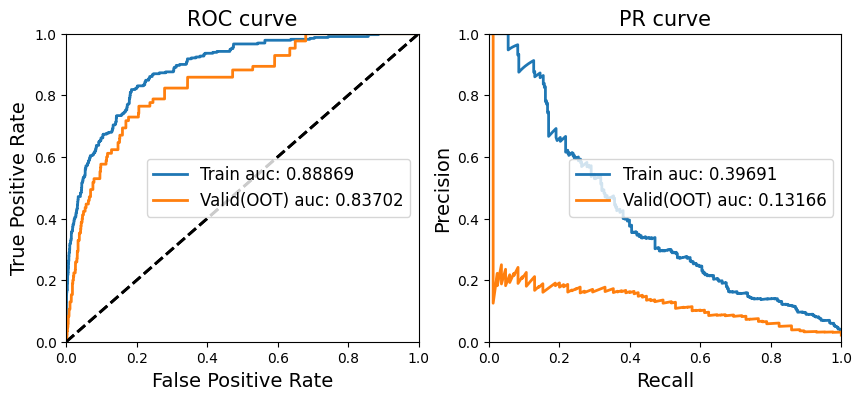

In [43]:
target_proba_sets = predict_proba_4eval_sets(clf, [(model_df[train_mask][cols], model_df[train_mask].target),
                     (model_df[valid_mask][cols], model_df[valid_mask].target)])

fig, metrics_df = evaluation_clf(target_proba_sets, ['Train', 'Valid(OOT)'], thres_method='f1')

display(metrics_df)

In [44]:
def custom_auc_scorer(model, X, y_true):
    y_pred = model.predict_proba(X)[:, 1] # Assuming binary classification
    return roc_auc_score(y_true, y_pred)

In [45]:
history = custom_forward_selection(model_df[train_mask][cols], model_df[train_mask].target,
                     model_df[valid_mask][cols], model_df[valid_mask].target, eval_sets=[(model_df[train_mask][cols], model_df[train_mask].target), (model_df[valid_mask][cols], model_df[valid_mask].target)], eval_names=['Train', 'Valid(OOT)'],
                     lst_feats_for_select=cols, cat_features=cat_features, scorer=custom_auc_scorer, method='permutation', model_params=catboost_params, maximize_eval_name='Valid(OOT)')

fs_step: 0it [00:00, ?it/s]

['col2663']
--- Iteration: 0. Number of feats: 1/43 ---
>> Building model: catboost


C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_15644\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.651638,0.368589,0.111765,0.073858,0.229607
1,Valid(OOT),0.806011,0.360643,0.151025,0.083135,0.823529


>> Done (0.79s)
['col2663', 'col2220']
--- Iteration: 1. Number of feats: 2/43 ---
>> Building model: catboost


C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_15644\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.744578,0.384053,0.155932,0.108363,0.277946
1,Valid(OOT),0.821166,0.385833,0.214433,0.130000,0.611765


fs_step: 1it [00:01,  1.63s/it]

>> Done (0.84s)
>> Excluded: ['col2220']
>> score increase_Train: -0.093
>> score increase_Valid(OOT): -0.015
>> Done (0.84s)
**************************************************
['col2663', 'col2341']
--- Iteration: 1. Number of feats: 2/42 ---
>> Building model: catboost


C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_15644\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.735073,0.352027,0.170999,0.110522,0.377644
1,Valid(OOT),0.830731,0.360526,0.218447,0.137615,0.529412


>> Done (0.89s)
['col2663', 'col2341', 'col2389']
--- Iteration: 2. Number of feats: 3/42 ---
>> Building model: catboost


C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_15644\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)
C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_15644\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.756271,0.451652,0.212824,0.194030,0.235650
1,Valid(OOT),0.841773,0.453915,0.277228,0.239316,0.329412


fs_step: 2it [00:03,  1.67s/it]

>> Done (0.82s)
>> Excluded: ['col2389']
>> score increase_Train: -0.021
>> score increase_Valid(OOT): -0.011
>> Done (0.82s)
**************************************************
['col2663', 'col2341', 'col2364']
--- Iteration: 2. Number of feats: 3/41 ---
>> Building model: catboost


C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_15644\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.735856,0.486405,0.159021,0.160991,0.157100
1,Valid(OOT),0.816036,0.485989,0.200358,0.118143,0.658824


>> Done (0.83s)
['col2663', 'col2341', 'col2364', 'col2292']
--- Iteration: 3. Number of feats: 4/41 ---
>> Building model: catboost


C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_15644\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.795687,0.220388,0.240766,0.220000,0.265861
1,Valid(OOT),0.823411,0.238958,0.183673,0.162162,0.211765


fs_step: 3it [00:04,  1.67s/it]

>> Done (0.82s)
>> Excluded: ['col2292']
>> score increase_Train: -0.060
>> score increase_Valid(OOT): -0.007
>> Done (0.83s)
**************************************************
['col2663', 'col2341', 'col2364', 'col2222']
--- Iteration: 3. Number of feats: 4/40 ---
>> Building model: catboost


C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_15644\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.773628,0.308115,0.227891,0.260700,0.202417
1,Valid(OOT),0.817358,0.310310,0.166667,0.129032,0.235294


>> Done (0.83s)
['col2663', 'col2341', 'col2364', 'col2222', 'col2221']
--- Iteration: 4. Number of feats: 5/40 ---
>> Building model: catboost


C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_15644\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.787855,0.228708,0.252163,0.213389,0.308157
1,Valid(OOT),0.827937,0.252677,0.230769,0.195122,0.282353


fs_step: 4it [00:06,  1.67s/it]

>> Done (0.85s)
>> Excluded: ['col2221']
>> score increase_Train: -0.014
>> score increase_Valid(OOT): -0.011
>> Done (0.85s)
**************************************************
['col2663', 'col2341', 'col2364', 'col2222', 'col2318']
--- Iteration: 4. Number of feats: 5/39 ---
>> Building model: catboost


C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_15644\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.815874,0.186107,0.271978,0.24937,0.299094
1,Valid(OOT),0.820805,0.181667,0.203077,0.13750,0.388235


>> Done (0.85s)
['col2663', 'col2341', 'col2364', 'col2222', 'col2318', 'col2216']
--- Iteration: 5. Number of feats: 6/39 ---
>> Building model: catboost


C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_15644\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.852972,0.116533,0.370044,0.360000,0.380665
1,Valid(OOT),0.825838,0.089424,0.193237,0.121581,0.470588


fs_step: 5it [00:08,  1.70s/it]

>> Done (0.90s)
>> Excluded: ['col2216']
>> score increase_Train: -0.037
>> score increase_Valid(OOT): -0.005
>> Done (0.90s)
**************************************************
['col2663', 'col2341', 'col2364', 'col2222', 'col2318', 'col2588']
--- Iteration: 5. Number of feats: 6/38 ---
>> Building model: catboost


C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_15644\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.852588,0.117240,0.367107,0.357143,0.377644
1,Valid(OOT),0.812402,0.108369,0.177778,0.129730,0.282353


>> Done (0.88s)
['col2663', 'col2341', 'col2364', 'col2222', 'col2318', 'col2588', 'col2505']
--- Iteration: 6. Number of feats: 7/38 ---
>> Building model: catboost


C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_15644\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.797185,0.355134,0.268398,0.256906,0.280967
1,Valid(OOT),0.805988,0.348098,0.201117,0.131868,0.423529


>> Done (0.94s)
['col2663', 'col2341', 'col2364', 'col2222', 'col2318', 'col2588', 'col2505', 'col2211']
--- Iteration: 7. Number of feats: 8/38 ---
>> Building model: catboost


C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_15644\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.865250,0.120698,0.396774,0.425606,0.371601
1,Valid(OOT),0.819718,0.106106,0.181818,0.143836,0.247059


fs_step: 6it [00:11,  2.05s/it]

>> Done (0.91s)
>> Excluded: ['col2211']
>> score increase_Train: -0.068
>> score increase_Valid(OOT): -0.014
>> Done (0.91s)
**************************************************
['col2663', 'col2341', 'col2364', 'col2222', 'col2318', 'col2588', 'col2505', 'col2244']
--- Iteration: 7. Number of feats: 8/37 ---
>> Building model: catboost


C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_15644\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.823103,0.224664,0.276364,0.230769,0.344411
1,Valid(OOT),0.816659,0.238274,0.219048,0.184000,0.270588


>> Done (0.86s)
['col2663', 'col2341', 'col2364', 'col2222', 'col2318', 'col2588', 'col2505', 'col2244', 'col2460']
--- Iteration: 8. Number of feats: 9/37 ---
>> Building model: catboost


C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_15644\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.840784,0.197048,0.295359,0.226904,0.422961
1,Valid(OOT),0.818169,0.212748,0.225108,0.178082,0.305882


fs_step: 7it [00:12,  1.95s/it]

>> Done (0.88s)
>> Excluded: ['col2460']
>> score increase_Train: -0.018
>> score increase_Valid(OOT): -0.002
>> Done (0.88s)
**************************************************
['col2663', 'col2341', 'col2364', 'col2222', 'col2318', 'col2588', 'col2505', 'col2244', 'col2214']
--- Iteration: 8. Number of feats: 9/36 ---
>> Building model: catboost


C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_15644\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.862849,0.130024,0.357143,0.367412,0.347432
1,Valid(OOT),0.828442,0.120048,0.201550,0.150289,0.305882


>> Done (0.94s)
['col2663', 'col2341', 'col2364', 'col2222', 'col2318', 'col2588', 'col2505', 'col2244', 'col2214', 'col2213']
--- Iteration: 9. Number of feats: 10/36 ---
>> Building model: catboost


C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_15644\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.872767,0.134536,0.395683,0.488889,0.332326
1,Valid(OOT),0.820372,0.114757,0.163265,0.144144,0.188235


>> Done (0.92s)
['col2663', 'col2341', 'col2364', 'col2222', 'col2318', 'col2588', 'col2505', 'col2244', 'col2214', 'col2213', 'col1828']
--- Iteration: 10. Number of feats: 11/36 ---
>> Building model: catboost


C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_15644\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.870834,0.121254,0.385502,0.423913,0.353474
1,Valid(OOT),0.825967,0.112785,0.158730,0.144231,0.176471


fs_step: 8it [00:15,  2.22s/it]

>> Done (0.94s)
>> Excluded: ['col1828']
>> score increase_Train: 0.002
>> score increase_Valid(OOT): -0.006
>> Done (0.94s)
**************************************************
['col2663', 'col2341', 'col2364', 'col2222', 'col2318', 'col2588', 'col2505', 'col2244', 'col2214', 'col2213', 'col2177']
--- Iteration: 10. Number of feats: 11/35 ---
>> Building model: catboost


C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_15644\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.865607,0.126625,0.381443,0.442231,0.335347
1,Valid(OOT),0.822269,0.079233,0.179775,0.111111,0.470588


>> Done (0.89s)
['col2663', 'col2341', 'col2364', 'col2222', 'col2318', 'col2588', 'col2505', 'col2244', 'col2214', 'col2213', 'col2177', 'col2174']
--- Iteration: 11. Number of feats: 12/35 ---
>> Building model: catboost


C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_15644\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.867271,0.125757,0.394464,0.461538,0.344411
1,Valid(OOT),0.834742,0.094025,0.176678,0.126263,0.294118


fs_step: 9it [00:17,  2.08s/it]

>> Done (0.88s)
>> Excluded: ['col2174']
>> score increase_Train: -0.002
>> score increase_Valid(OOT): -0.012
>> Done (0.88s)
**************************************************
['col2663', 'col2341', 'col2364', 'col2222', 'col2318', 'col2588', 'col2505', 'col2244', 'col2214', 'col2213', 'col2177', 'col2038']
--- Iteration: 11. Number of feats: 12/34 ---
>> Building model: catboost


C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_15644\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.869485,0.130377,0.389474,0.464435,0.335347
1,Valid(OOT),0.836816,0.074448,0.186253,0.114754,0.494118


>> Done (1.11s)
['col2663', 'col2341', 'col2364', 'col2222', 'col2318', 'col2588', 'col2505', 'col2244', 'col2214', 'col2213', 'col2177', 'col2038', 'col628']
--- Iteration: 12. Number of feats: 13/34 ---
>> Building model: catboost


C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_15644\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.862920,0.121421,0.388254,0.421986,0.359517
1,Valid(OOT),0.833131,0.093958,0.183267,0.138554,0.270588


>> Done (1.20s)
['col2663', 'col2341', 'col2364', 'col2222', 'col2318', 'col2588', 'col2505', 'col2244', 'col2214', 'col2213', 'col2177', 'col2038', 'col628', 'col2039']
--- Iteration: 13. Number of feats: 14/34 ---
>> Building model: catboost


C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_15644\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.861592,0.125283,0.382759,0.445783,0.335347
1,Valid(OOT),0.831928,0.077448,0.199488,0.127451,0.458824


>> Done (1.14s)
['col2663', 'col2341', 'col2364', 'col2222', 'col2318', 'col2588', 'col2505', 'col2244', 'col2214', 'col2213', 'col2177', 'col2038', 'col628', 'col2039', 'col676']
--- Iteration: 14. Number of feats: 15/34 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.865943,0.122761,0.377104,0.425856,0.338369
1,Valid(OOT),0.843394,0.086698,0.213793,0.151220,0.364706


fs_step: 10it [00:22,  2.84s/it]

>> Done (1.09s)
>> Excluded: ['col676']
>> score increase_Train: -0.004
>> score increase_Valid(OOT): -0.011
>> Done (1.09s)
**************************************************
['col2663', 'col2341', 'col2364', 'col2222', 'col2318', 'col2588', 'col2505', 'col2244', 'col2214', 'col2213', 'col2177', 'col2038', 'col628', 'col2039', 'col1921']
--- Iteration: 14. Number of feats: 15/33 ---
>> Building model: catboost


C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_15644\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.867471,0.108275,0.379310,0.361644,0.398792
1,Valid(OOT),0.817771,0.080201,0.177143,0.116981,0.364706


>> Done (1.12s)
['col2663', 'col2341', 'col2364', 'col2222', 'col2318', 'col2588', 'col2505', 'col2244', 'col2214', 'col2213', 'col2177', 'col2038', 'col628', 'col2039', 'col1921', 'col1845']
--- Iteration: 15. Number of feats: 16/33 ---
>> Building model: catboost


C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_15644\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.869881,0.115314,0.376396,0.398649,0.356495
1,Valid(OOT),0.830105,0.080563,0.183432,0.122530,0.364706


fs_step: 11it [00:24,  2.64s/it]

>> Done (1.07s)
>> Excluded: ['col1845']
>> score increase_Train: -0.002
>> score increase_Valid(OOT): -0.012
>> Done (1.07s)
**************************************************
['col2663', 'col2341', 'col2364', 'col2222', 'col2318', 'col2588', 'col2505', 'col2244', 'col2214', 'col2213', 'col2177', 'col2038', 'col628', 'col2039', 'col1921', 'col1508']
--- Iteration: 15. Number of feats: 16/32 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.878551,0.143025,0.365422,0.522472,0.280967
1,Valid(OOT),0.836627,0.068634,0.199029,0.125382,0.482353


>> Done (1.10s)
['col2663', 'col2341', 'col2364', 'col2222', 'col2318', 'col2588', 'col2505', 'col2244', 'col2214', 'col2213', 'col2177', 'col2038', 'col628', 'col2039', 'col1921', 'col1508', 'col2293']
--- Iteration: 16. Number of feats: 17/32 ---
>> Building model: catboost


C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_15644\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.881111,0.121606,0.386555,0.435606,0.347432
1,Valid(OOT),0.833627,0.065348,0.209246,0.131902,0.505882


>> Done (1.08s)
['col2663', 'col2341', 'col2364', 'col2222', 'col2318', 'col2588', 'col2505', 'col2244', 'col2214', 'col2213', 'col2177', 'col2038', 'col628', 'col2039', 'col1921', 'col1508', 'col2293', 'col2245']
--- Iteration: 17. Number of feats: 18/32 ---
>> Building model: catboost


C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_15644\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.879731,0.128431,0.374126,0.443983,0.323263
1,Valid(OOT),0.832223,0.079658,0.185185,0.135135,0.294118


>> Done (1.05s)
['col2663', 'col2341', 'col2364', 'col2222', 'col2318', 'col2588', 'col2505', 'col2244', 'col2214', 'col2213', 'col2177', 'col2038', 'col628', 'col2039', 'col1921', 'col1508', 'col2293', 'col2245', 'col2660']
--- Iteration: 18. Number of feats: 19/32 ---
>> Building model: catboost


C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_15644\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.883919,0.115219,0.385757,0.379009,0.392749
1,Valid(OOT),0.836120,0.078731,0.215278,0.152709,0.364706


fs_step: 12it [00:28,  3.15s/it]

>> Done (1.10s)
>> Excluded: ['col2660']
>> score increase_Train: -0.004
>> score increase_Valid(OOT): -0.004
>> Done (1.10s)
**************************************************
['col2663', 'col2341', 'col2364', 'col2222', 'col2318', 'col2588', 'col2505', 'col2244', 'col2214', 'col2213', 'col2177', 'col2038', 'col628', 'col2039', 'col1921', 'col1508', 'col2293', 'col2245', 'col2014']
--- Iteration: 18. Number of feats: 19/31 ---
>> Building model: catboost


C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_15644\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.886053,0.114304,0.369138,0.369697,0.368580
1,Valid(OOT),0.838511,0.079880,0.205128,0.148936,0.329412


>> Done (1.09s)
['col2663', 'col2341', 'col2364', 'col2222', 'col2318', 'col2588', 'col2505', 'col2244', 'col2214', 'col2213', 'col2177', 'col2038', 'col628', 'col2039', 'col1921', 'col1508', 'col2293', 'col2245', 'col2014', 'col1967']
--- Iteration: 19. Number of feats: 20/31 ---
>> Building model: catboost


C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_15644\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.879705,0.112478,0.359649,0.348442,0.371601
1,Valid(OOT),0.832730,0.072852,0.185075,0.124000,0.364706


>> Done (1.08s)
['col2663', 'col2341', 'col2364', 'col2222', 'col2318', 'col2588', 'col2505', 'col2244', 'col2214', 'col2213', 'col2177', 'col2038', 'col628', 'col2039', 'col1921', 'col1508', 'col2293', 'col2245', 'col2014', 'col1967', 'col1827']
--- Iteration: 20. Number of feats: 21/31 ---
>> Building model: catboost


C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_15644\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.884025,0.138129,0.383721,0.535135,0.299094
1,Valid(OOT),0.827210,0.073875,0.196721,0.136364,0.352941


>> Done (1.07s)
['col2663', 'col2341', 'col2364', 'col2222', 'col2318', 'col2588', 'col2505', 'col2244', 'col2214', 'col2213', 'col2177', 'col2038', 'col628', 'col2039', 'col1921', 'col1508', 'col2293', 'col2245', 'col2014', 'col1967', 'col1827', 'col500']
--- Iteration: 21. Number of feats: 22/31 ---
>> Building model: catboost


C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_15644\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.887572,0.132527,0.393881,0.536458,0.311178
1,Valid(OOT),0.832150,0.078618,0.185714,0.133333,0.305882


fs_step: 13it [00:32,  3.50s/it]

>> Done (1.06s)
>> Excluded: ['col500']
>> score increase_Train: -0.004
>> score increase_Valid(OOT): -0.005
>> Done (1.06s)
**************************************************
['col2663', 'col2341', 'col2364', 'col2222', 'col2318', 'col2588', 'col2505', 'col2244', 'col2214', 'col2213', 'col2177', 'col2038', 'col628', 'col2039', 'col1921', 'col1508', 'col2293', 'col2245', 'col2014', 'col1967', 'col1827', 'col620']
--- Iteration: 21. Number of feats: 22/30 ---
>> Building model: catboost


C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_15644\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.883147,0.116564,0.388797,0.427536,0.356495
1,Valid(OOT),0.834394,0.068174,0.201592,0.130137,0.447059


>> Done (1.09s)
['col2663', 'col2341', 'col2364', 'col2222', 'col2318', 'col2588', 'col2505', 'col2244', 'col2214', 'col2213', 'col2177', 'col2038', 'col628', 'col2039', 'col1921', 'col1508', 'col2293', 'col2245', 'col2014', 'col1967', 'col1827', 'col620', 'col1945']
--- Iteration: 22. Number of feats: 23/30 ---
>> Building model: catboost


C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_15644\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.883273,0.117777,0.380952,0.417266,0.350453
1,Valid(OOT),0.840328,0.074843,0.210884,0.148325,0.364706


fs_step: 14it [00:35,  3.10s/it]

>> Done (1.07s)
>> Excluded: ['col1945']
>> score increase_Train: -0.000
>> score increase_Valid(OOT): -0.006
>> Done (1.07s)
**************************************************
['col2663', 'col2341', 'col2364', 'col2222', 'col2318', 'col2588', 'col2505', 'col2244', 'col2214', 'col2213', 'col2177', 'col2038', 'col628', 'col2039', 'col1921', 'col1508', 'col2293', 'col2245', 'col2014', 'col1967', 'col1827', 'col620', 'col268']
--- Iteration: 22. Number of feats: 23/29 ---
>> Building model: catboost


C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_15644\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.881581,0.125271,0.371930,0.443515,0.320242
1,Valid(OOT),0.848619,0.076403,0.197279,0.138756,0.341176


>> Done (1.06s)
['col2663', 'col2341', 'col2364', 'col2222', 'col2318', 'col2588', 'col2505', 'col2244', 'col2214', 'col2213', 'col2177', 'col2038', 'col628', 'col2039', 'col1921', 'col1508', 'col2293', 'col2245', 'col2014', 'col1967', 'col1827', 'col620', 'col268', 'col2317']
--- Iteration: 23. Number of feats: 24/29 ---
>> Building model: catboost


C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_15644\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.884014,0.122164,0.400691,0.467742,0.350453
1,Valid(OOT),0.835489,0.083320,0.185328,0.137931,0.282353


>> Done (1.07s)
['col2663', 'col2341', 'col2364', 'col2222', 'col2318', 'col2588', 'col2505', 'col2244', 'col2214', 'col2213', 'col2177', 'col2038', 'col628', 'col2039', 'col1921', 'col1508', 'col2293', 'col2245', 'col2014', 'col1967', 'col1827', 'col620', 'col268', 'col2317', 'col2215']
--- Iteration: 24. Number of feats: 25/29 ---
>> Building model: catboost


C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_15644\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.881787,0.123340,0.397906,0.471074,0.344411
1,Valid(OOT),0.832979,0.067353,0.190955,0.121406,0.447059


>> Done (1.10s)
['col2663', 'col2341', 'col2364', 'col2222', 'col2318', 'col2588', 'col2505', 'col2244', 'col2214', 'col2213', 'col2177', 'col2038', 'col628', 'col2039', 'col1921', 'col1508', 'col2293', 'col2245', 'col2014', 'col1967', 'col1827', 'col620', 'col268', 'col2317', 'col2215', 'col264']
--- Iteration: 25. Number of feats: 26/29 ---
>> Building model: catboost


C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_15644\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.877982,0.121075,0.379130,0.446721,0.329305
1,Valid(OOT),0.839922,0.078267,0.195122,0.138614,0.329412


fs_step: 15it [00:39,  3.48s/it]

>> Done (1.11s)
>> Excluded: ['col264']
>> score increase_Train: 0.004
>> score increase_Valid(OOT): -0.007
>> Done (1.11s)
**************************************************
['col2663', 'col2341', 'col2364', 'col2222', 'col2318', 'col2588', 'col2505', 'col2244', 'col2214', 'col2213', 'col2177', 'col2038', 'col628', 'col2039', 'col1921', 'col1508', 'col2293', 'col2245', 'col2014', 'col1967', 'col1827', 'col620', 'col268', 'col2317', 'col2215', 'col644']
--- Iteration: 25. Number of feats: 26/28 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.878141,0.120337,0.387543,0.453441,0.338369
1,Valid(OOT),0.840397,0.076378,0.199377,0.135593,0.376471


>> Done (1.11s)
['col2663', 'col2341', 'col2364', 'col2222', 'col2318', 'col2588', 'col2505', 'col2244', 'col2214', 'col2213', 'col2177', 'col2038', 'col628', 'col2039', 'col1921', 'col1508', 'col2293', 'col2245', 'col2014', 'col1967', 'col1827', 'col620', 'col268', 'col2317', 'col2215', 'col644', 'col456']
--- Iteration: 26. Number of feats: 27/28 ---
>> Building model: catboost


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.881443,0.115226,0.385502,0.423913,0.353474
1,Valid(OOT),0.846809,0.069754,0.198953,0.127946,0.447059


fs_step: 16it [00:41,  3.10s/it]

>> Done (1.12s)
>> Excluded: ['col456']
>> score increase_Train: -0.003
>> score increase_Valid(OOT): -0.006
>> Done (1.12s)
**************************************************
['col2663', 'col2341', 'col2364', 'col2222', 'col2318', 'col2588', 'col2505', 'col2244', 'col2214', 'col2213', 'col2177', 'col2038', 'col628', 'col2039', 'col1921', 'col1508', 'col2293', 'col2245', 'col2014', 'col1967', 'col1827', 'col620', 'col268', 'col2317', 'col2215', 'col644', 'col1927']
--- Iteration: 26. Number of feats: 27/27 ---
>> Building model: catboost


C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_15644\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.881672,0.123341,0.388985,0.452000,0.341390
1,Valid(OOT),0.843829,0.084078,0.218310,0.155779,0.364706


fs_step: 17it [00:42,  2.51s/it]

>> Done (1.08s)
**************************************************
>> Finish. Number of features in final subset: 27


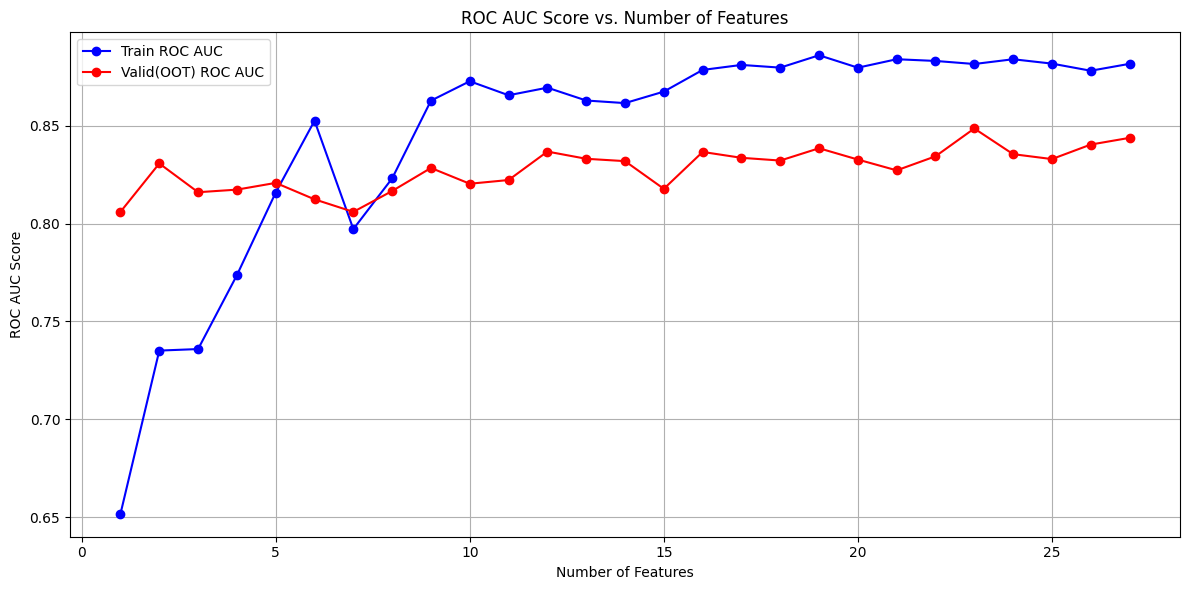

In [46]:

train_roc_aucs = [df[df['sample'] == 'Train']['roc_auc'].values[0] for df in history['metrics']]
valid_roc_aucs = [df[df['sample'] == 'Valid(OOT)']['roc_auc'].values[0] for df in history['metrics']]

num_features = history['num_feats']
plt.figure(figsize=(12, 6))
plt.plot(num_features, train_roc_aucs, marker='o', label='Train ROC AUC', color='blue')
plt.plot(num_features, valid_roc_aucs, marker='o', label='Valid(OOT) ROC AUC', color='red')
plt.title('ROC AUC Score vs. Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('ROC AUC Score')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [56]:
cols = history['sel_feats'][-1][:10].copy()
cat_features = model_df[cols].select_dtypes(include=['object']).columns.tolist()

In [57]:
clf = build_cb_model(model_df[train_mask][cols], model_df[train_mask].target,
                     model_df[valid_mask][cols], model_df[valid_mask].target, 
                     cat_features=cat_features, params=catboost_params)

0:	test: 0.7009471	best: 0.7009471 (0)	total: 6.18ms	remaining: 1.23s
50:	test: 0.8006536	best: 0.8040819 (38)	total: 199ms	remaining: 580ms
100:	test: 0.8133790	best: 0.8138632 (98)	total: 373ms	remaining: 366ms
150:	test: 0.8181146	best: 0.8188620 (137)	total: 545ms	remaining: 177ms
199:	test: 0.8203719	best: 0.8203719 (199)	total: 719ms	remaining: 0us

bestTest = 0.8203718833
bestIteration = 199



C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_15644\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)
C:\Users\MSI Prestige\AppData\Local\Temp\ipykernel_15644\3934987077.py:67: RuntimeWarning: invalid value encountered in divide
  f1 = 2 * prec * rec / (prec + rec)


,sample,roc_auc,Best thres,F1,Prec,Rec
0,Train,0.872767,0.134536,0.395683,0.488889,0.332326
1,Valid(OOT),0.820372,0.114757,0.163265,0.144144,0.188235
2,Test(OOT),0.818218,0.062597,0.131455,0.072539,0.700000


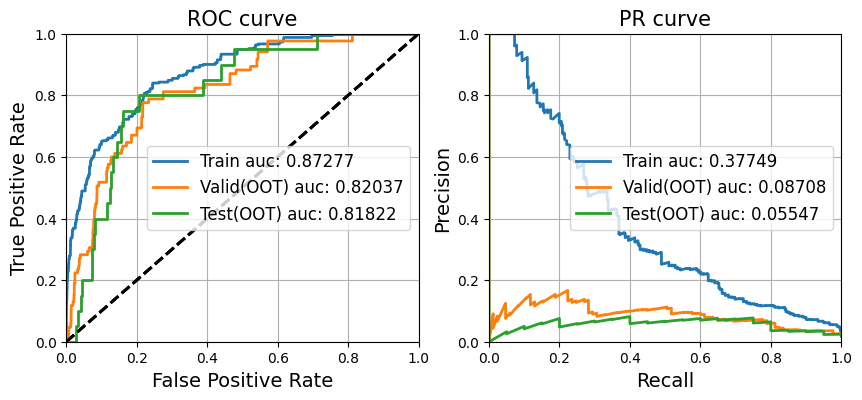

In [58]:
target_proba_sets = predict_proba_4eval_sets(clf, [(model_df[train_mask][cols], model_df[train_mask].target),
                     (model_df[valid_mask][cols], model_df[valid_mask].target), 
                     (model_df[oot_mask][cols], model_df[oot_mask].target)])

fig, metrics_df = evaluation_clf(target_proba_sets, ['Train', 'Valid(OOT)', 'Test(OOT)'], thres_method='J')

display(metrics_df)

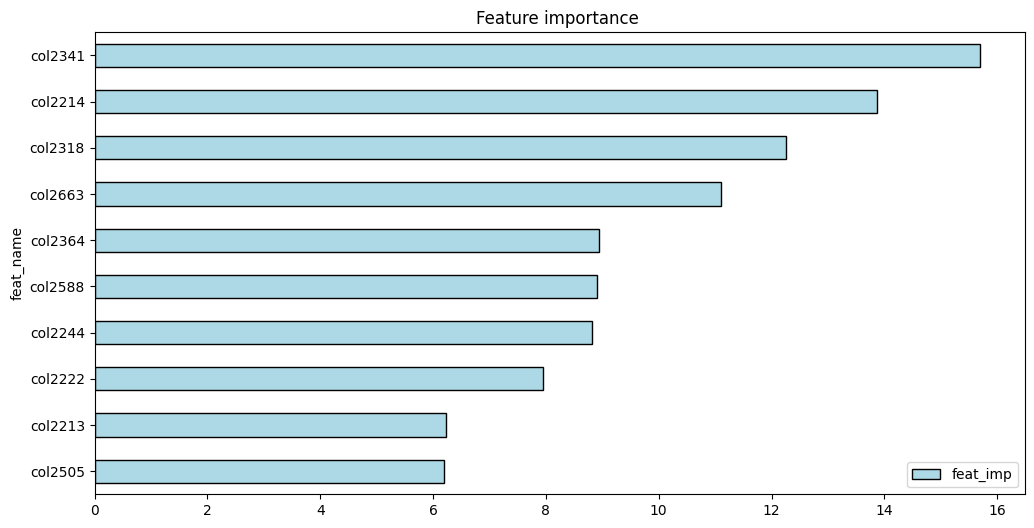

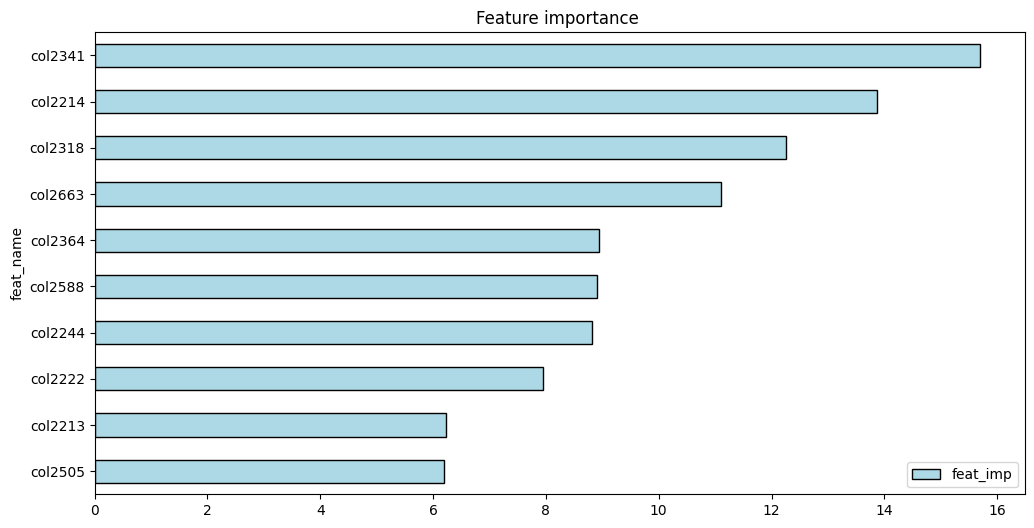

In [59]:
plot_feature_importance(clf)

In [60]:
model_df['proba'] = clf.predict_proba(model_df[cols])[:,1]

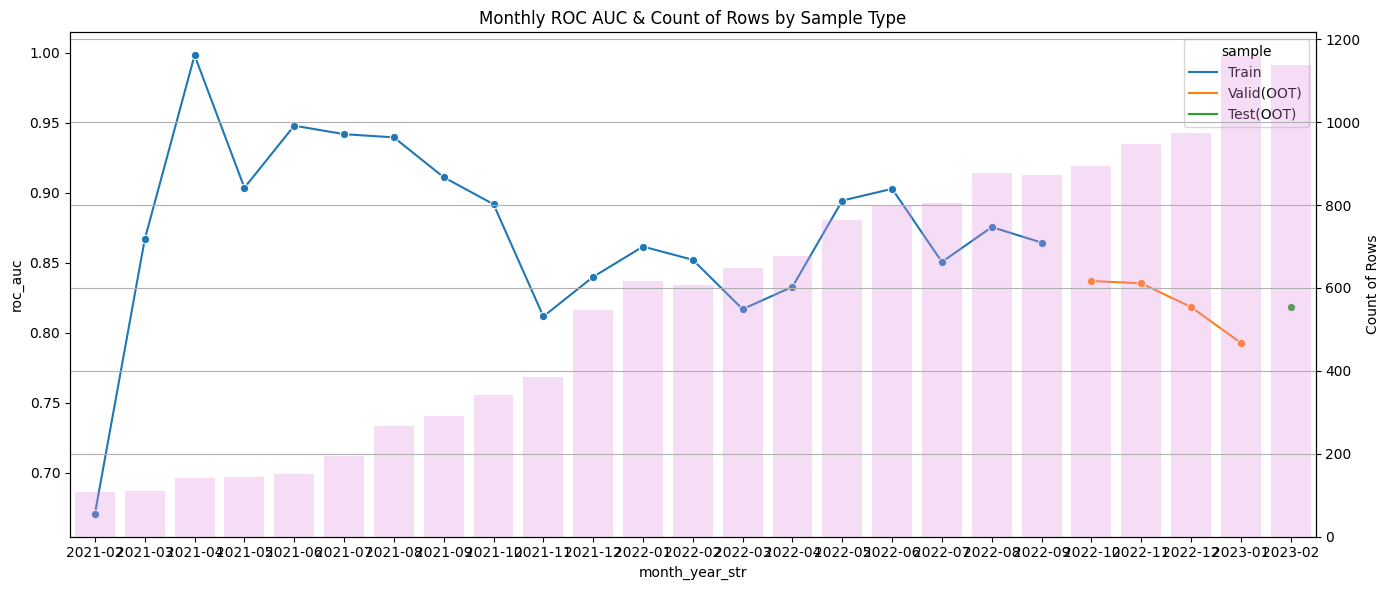

In [61]:
roc_df = model_df.groupby(['year_month', 'sample']).apply(lambda x: roc_auc_score(x['target'], x['proba'])).reset_index()
roc_df.columns = ['year_month', 'sample', 'roc_auc']
roc_df['month_year_str'] = roc_df['year_month'].astype(str)

# Calculate the count for each month and sample
count_df = model_df.groupby(['year_month', 'sample']).size().reset_index()
count_df.columns = ['year_month', 'sample', 'count']

# Merge the two dataframes on year_month and sample
roc_df = pd.merge(roc_df, count_df, on=['year_month', 'sample'])

# Convert year_month to string for plotting
roc_df['month_year_str'] = roc_df['year_month'].astype(str)

# Plotting using seaborn
plt.figure(figsize=(14, 6))

# Plot ROC AUC
sns.lineplot(data=roc_df, x='month_year_str', y='roc_auc', hue='sample', marker='o')

ax2 = plt.gca().twinx()
# sns.barplot(data=roc_df, x='month_year_str', y='count', ax=ax2, alpha=0.3)
sns.barplot(data=roc_df, x='month_year_str', y='count', ax=ax2, alpha=0.3, color="violet")
# Set labels, title, and legend
plt.gca().set_ylabel("ROC AUC")
# plt.gca().set_ylim([0.0, 1.0])
ax2.set_ylabel("Count of Rows")
plt.gca().set_xlabel("Month")

plt.title("Monthly ROC AUC & Count of Rows by Sample Type")
plt.grid(True)

labels = roc_df['month_year_str'].unique()
ax2.set_xticklabels(labels=labels, rotation=45, ha='right')

plt.tight_layout()
plt.show()